In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.utils.data as Data
from torchvision import transforms, datasets

In [35]:
# 文件读取
def get_Data(data_path):

    data=pd.read_excel(data_path)
    data=data.iloc[:,:3]  # 以三个特征作为数据
    label=data.iloc[:,2:] # 取最后一个特征作为标签
    print(data.head())
    print(label.head())
    return data,label

In [36]:
# 数据预处理
def normalization(data,label):

    mm_x=MinMaxScaler() # 导入sklearn的预处理容器
    mm_y=MinMaxScaler()
    data=data.values    # 将pd的系列格式转换为np的数组格式
    label=label.values
    data=mm_x.fit_transform(data) # 对数据和标签进行归一化等处理
    label=mm_y.fit_transform(label)
    return data,label,mm_y

In [43]:
# 时间向量转换
def split_windows(data,seq_length):

    x=[]
    y=[]
    for i in range(len(data)-seq_length-1): # range的范围需要减去时间步长和1
        _x=data[i:(i+seq_length),:]
        _y=data[i+seq_length,-1]
        x.append(_x)
        y.append(_y)
    x,y=np.array(x),np.array(y)
    print('x.shape,y.shape=\n',x.shape,y.shape)
    return x,y

In [44]:
# 数据分离
def split_data(x,y,split_ratio):

    train_size=int(len(y)*split_ratio)
    test_size=len(y)-train_size

    x_data=Variable(torch.Tensor(np.array(x)))
    y_data=Variable(torch.Tensor(np.array(y)))

    x_train=Variable(torch.Tensor(np.array(x[0:train_size])))
    y_train=Variable(torch.Tensor(np.array(y[0:train_size])))
    y_test=Variable(torch.Tensor(np.array(y[train_size:len(y)])))
    x_test=Variable(torch.Tensor(np.array(x[train_size:len(x)])))

    print('x_data.shape,y_data.shape,x_train.shape,y_train.shape,x_test.shape,y_test.shape:\n{}{}{}{}{}{}'
    .format(x_data.shape,y_data.shape,x_train.shape,y_train.shape,x_test.shape,y_test.shape))

    return x_data,y_data,x_train,y_train,x_test,y_test

In [52]:
# 数据装入
def data_generator(x_train,y_train,x_test,y_test,n_iters,batch_size):

    num_epochs=n_iters/(len(x_train)/batch_size) # n_iters代表一次迭代
    num_epochs=int(num_epochs)
    train_dataset=Data.TensorDataset(x_train,y_train)
    test_dataset=Data.TensorDataset(x_train,y_train)
    train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=False,drop_last=True) # 加载数据集,使数据集可迭代
    test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,drop_last=True)

    return train_loader,test_loader,num_epochs

In [90]:
# 定义模型
from turtle import forward
import torch.nn as nn
import torch.nn.functional as F

# 定义一个类
class Net(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size,batch_size,seq_length) -> None:
        super(Net,self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.output_size=output_size
        self.batch_size=batch_size
        self.seq_length=seq_length
        self.num_directions=1 # 单向LSTM

        self.lstm=nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True) # LSTM层
        self.fc=nn.Linear(hidden_size,output_size) # 全连接层

    def forward(self,x):
        # h_0=Variable(torch.zeros(self.num_layers,x.size(0),self.output_size))
        # c_0=Variable(torch.zeros(self.num_layers,x.size(0),self.output_size))# 初始化h_0和c_0

        # pred, (h_out, _) = self.lstm(x, (h_0, c_0))
        # h_out = h_out.view(-1, self.hidden_size)
        # out = self.fc(h_out)

        # e.g.  x(10,3,100) 三个句子，十个单词，一百维的向量,nn.LSTM(input_size=100,hidden_size=20,num_layers=4)
        # out.shape=(10,3,20) h/c.shape=(4,b,20)
        batch_size, seq_len = x.size()[0], x.size()[1]    # x.shape=(604,3,3)
        h_0 = torch.randn(self.num_directions * self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.randn(self.num_directions * self.num_layers, x.size(0), self.hidden_size)
        # output(batch_size, seq_len, num_directions * hidden_size)
        output, _ = self.lstm(x, (h_0, c_0)) # output(5, 30, 64)
        pred = self.fc(output)  # (5, 30, 1)
        pred = pred[:, -1, :]  # (5, 1)
        return pred

In [91]:
# 参数设置
seq_length=3 # 时间步长
input_size=3
num_layers=6
hidden_size=12
batch_size=64
n_iters=5000
lr=0.001
output_size=1
split_ratio=0.9
path='.\data.xls'
moudle=Net(input_size,hidden_size,num_layers,output_size,batch_size,seq_length)
criterion=torch.nn.MSELoss()
optimizer=torch.optim.Adam(moudle.parameters(),lr=lr)
print(moudle)

Net(
  (lstm): LSTM(3, 12, num_layers=6, batch_first=True)
  (fc): Linear(in_features=12, out_features=1, bias=True)
)


In [92]:
# 数据导入
data,label=get_Data(path)
data,label,mm_y=normalization(data,label)
x,y=split_windows(data,seq_length)
x_data,y_data,x_train,y_train,x_test,y_test=split_data(x,y,split_ratio)
train_loader,test_loader,num_epochs=data_generator(x_train,y_train,x_test,y_test,n_iters,batch_size)

   导叶开度  燃料流量m3N/h  压气机出口温度
0     1     0.0089      1.0
1     2     0.0179      2.0
2     3     0.0269      2.0
3     6     0.0359      3.0
4     8     0.0449      4.0
   压气机出口温度
0      1.0
1      2.0
2      2.0
3      3.0
4      4.0
x.shape,y.shape=
 (604, 3, 3) (604,)
x_data.shape,y_data.shape,x_train.shape,y_train.shape,x_test.shape,y_test.shape:
torch.Size([604, 3, 3])torch.Size([604])torch.Size([543, 3, 3])torch.Size([543])torch.Size([61, 3, 3])torch.Size([61])


In [93]:
# train
iter=0
for epochs in range(num_epochs):
  for i,(batch_x, batch_y) in enumerate (train_loader):
    outputs = moudle(batch_x)
    optimizer.zero_grad()   # 将每次传播时的梯度累积清除
    # print(outputs.shape, batch_y.shape)
    loss = criterion(outputs,batch_y) # 计算损失
    loss.backward() # 反向传播
    optimizer.step()
    iter+=1
    if iter % 100 == 0:
      print("iter: %d, loss: %1.5f" % (iter, loss.item()))

c:\Users\zgtstxyhs\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


iter: 100, loss: 0.02329
iter: 200, loss: 0.10282
iter: 300, loss: 0.02548
iter: 400, loss: 0.10001
iter: 500, loss: 0.00962
iter: 600, loss: 0.00524
iter: 700, loss: 0.00088
iter: 800, loss: 0.00394
iter: 900, loss: 0.00101
iter: 1000, loss: 0.00378
iter: 1100, loss: 0.00064
iter: 1200, loss: 0.00363
iter: 1300, loss: 0.00052
iter: 1400, loss: 0.00364
iter: 1500, loss: 0.00081
iter: 1600, loss: 0.00341
iter: 1700, loss: 0.00062
iter: 1800, loss: 0.00353
iter: 1900, loss: 0.00106
iter: 2000, loss: 0.00353
iter: 2100, loss: 0.00048
iter: 2200, loss: 0.00408
iter: 2300, loss: 0.00059
iter: 2400, loss: 0.00331
iter: 2500, loss: 0.00039
iter: 2600, loss: 0.00393
iter: 2700, loss: 0.00068
iter: 2800, loss: 0.00337
iter: 2900, loss: 0.00031
iter: 3000, loss: 0.00370
iter: 3100, loss: 0.00053
iter: 3200, loss: 0.00320
iter: 3300, loss: 0.00028
iter: 3400, loss: 0.00381
iter: 3500, loss: 0.00051
iter: 3600, loss: 0.00325
iter: 3700, loss: 0.00031
iter: 3800, loss: 0.00349
iter: 3900, loss: 0.0

In [94]:
print(x_data.shape)

torch.Size([604, 3, 3])


In [95]:
moudle.eval()
train_predict = moudle(x_data)

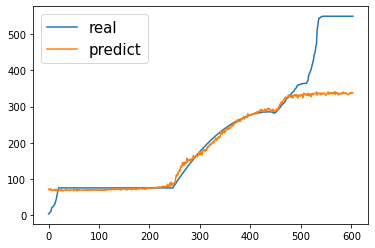

MAE/RMSE
35.114613
75.8706


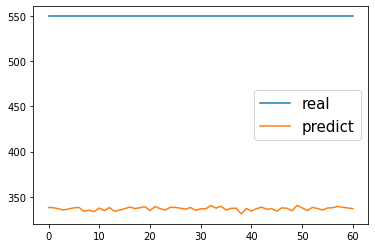

MAE/RMSE
213.30313
213.31061


In [96]:
def result(x_data, y_data):
  moudle.eval()
  train_predict = moudle(x_data)

  data_predict = train_predict.data.numpy()
  y_data_plot = y_data.data.numpy()
  y_data_plot = np.reshape(y_data_plot, (-1,1))  
  data_predict = mm_y.inverse_transform(data_predict)
  y_data_plot = mm_y.inverse_transform(y_data_plot)

  plt.plot(y_data_plot)
  plt.plot(data_predict)
  plt.legend(('real', 'predict'),fontsize='15')
  plt.show()

  print('MAE/RMSE')
  print(mean_absolute_error(y_data_plot, data_predict))
  print(np.sqrt(mean_squared_error(y_data_plot, data_predict) ))

result(x_data, y_data)
result(x_test,y_test)